In [ ]:
import geopandas as gpd
from pathlib import Path
import contextily as ctx
import matplotlib.pyplot as plt
from shapely.geometry import box
from lxml import etree
import polyline
import requests

In [2]:
PARQUET_FILE = "outputs/osm_amazonia_streets.parquet"
EXAMPLE_BBOX = [-60.983251, -3.700466, -58.927435, -2.525313]
OUTPUT_OSM_FILE = "outputs/rivers_amazon.osm"
OUTPUT_OSM_PBF_FILE = OUTPUT_OSM_FILE + ".pbf"

In [3]:
# Read rivers data
parquet_path = Path(PARQUET_FILE)
if not parquet_path.exists():
    print(f"Converting zip to parquet: {parquet_path}")
    # Read the shapefile from the zip file and convert to GeoParquet
    rivers_db = gpd.read_file("osm_amazonia_streets.zip")
    # Check if the output directory exists, create if not
    parquet_path.parent.mkdir(parents=True, exist_ok=True)
    # Save the GeoDataFrame to a parquet file
    rivers_db.to_parquet(parquet_path)
    print(f"Converted zip to parquet: {parquet_path}")
else:
    print(f"Loading parquet file: {parquet_path}")
    rivers_parquet = gpd.read_parquet(parquet_path)

Loading parquet file: outputs/osm_amazonia_streets.parquet


In [4]:
rivers_parquet.head()

,osm_id,edge_id,lastchange,code,fclass,name,int_name,ref,oneway,maxspeed,...,layer,surface,lanes,gauge,electrif,voltage,frequency,operator,type,geometry
0,28939861,42839273,2012-09-09T12:23:02Z,5401,ferry,None,None,None,B,0,...,0,None,0,None,None,None,None,None,unkown,"LINESTRING (-51.80241 3.88617, -51.80236 3.885..."
1,29231080,43215316,2018-02-05T17:59:52Z,5401,ferry,None,None,None,B,0,...,0,None,0,None,None,None,None,None,unkown,"LINESTRING (-57.16993 5.78079, -57.16937 5.781..."
2,30764548,44793966,2020-04-07T14:40:48Z,5401,ferry,Demerara River Speed Boat Crossing,Demerara River Speed Boat Crossing,None,B,0,...,0,None,0,None,None,None,None,None,unkown,"LINESTRING (-58.16857 6.8096, -58.16893 6.8099..."
3,30877064,44929891,2014-08-10T07:23:11Z,5401,ferry,None,None,None,B,0,...,0,None,0,None,None,None,None,None,unkown,"LINESTRING (-60.67027 -7.52365, -60.67107 -7.5..."
4,30879701,44933271,2020-04-07T09:36:56Z,5401,ferry,None,None,BR-230,B,0,...,0,None,0,None,None,None,None,None,unkown,"LINESTRING (-55.96301 -4.29253, -55.96361 -4.2..."


In [5]:
rivers_parquet.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2024498 entries, 0 to 2024497
Data columns (total 39 columns):
 #   Column      Dtype   
---  ------      -----   
 0   osm_id      int64   
 1   edge_id     int64   
 2   lastchange  object  
 3   code        object  
 4   fclass      object  
 5   name        object  
 6   int_name    object  
 7   ref         object  
 8   oneway      object  
 9   maxspeed    int32   
 10  maxwidth    float64 
 11  maxheight   float64 
 12  maxweight   float64 
 13  a_foot      object  
 14  a_cycle     object  
 15  a_motor     object  
 16  a_hgv       object  
 17  a_psv       object  
 18  ete         int64   
 19  speed       int32   
 20  length      int64   
 21  start_lat   float64 
 22  start_lon   float64 
 23  end_lat     float64 
 24  end_lon     float64 
 25  start_node  object  
 26  end_node    object  
 27  bridge      object  
 28  tunnel      object  
 29  layer       int32   
 30  surface     object  
 31  lanes       int3

In [6]:
rivers_parquet["fclass"].value_counts()

fclass
boat             895837
residential      674394
unclassified     124769
tertiary          77027
track             67675
secondary         37513
primary           34173
service           33615
path              26571
footway           20328
trunk             15006
living_street      9500
pedestrian         1675
cycleway            869
ferry               846
bridleway           842
road                792
rail                438
steps               416
narrow_gauge        132
motorway             70
tram                  1
Name: count, dtype: int64

In [7]:
# Categorize fclass values into navigable rivers, roads, and others
def categorize_fclass(fclass):
    # Navigable waterways
    navigable_water = ["ferry", "boat"]

    # Road types
    roads = [
        "motorway",
        "trunk",
        "primary",
        "secondary",
        "tertiary",
        "unclassified",
        "residential",
        "service",
        "track",
        "path",
        "footway",
        "cycleway",
        "bridleway",
        "steps",
        "living_street",
        "pedestrian",
        "motorway_link",
        "trunk_link",
        "primary_link",
        "secondary_link",
        "tertiary_link",
    ]

    if fclass in navigable_water:
        return "navigable_rivers"
    elif fclass in roads:
        return "roads"
    else:
        return "others"


# Apply categorization to the dataframe
rivers_parquet["category"] = rivers_parquet["fclass"].apply(categorize_fclass)

# Show the distribution of categories
print("Category distribution:")
print(rivers_parquet["category"].value_counts())
print("\nDetailed fclass distribution by category:")
print(rivers_parquet.groupby("category")["fclass"].value_counts())

Category distribution:
category
roads               1124443
navigable_rivers     896683
others                 3372
Name: count, dtype: int64

Detailed fclass distribution by category:
category          fclass       
navigable_rivers  boat             895837
                  ferry               846
others            road                792
                  rail                438
                  narrow_gauge        132
                  tram                  1
roads             residential      674394
                  unclassified     124769
                  tertiary          77027
                  track             67675
                  secondary         37513
                  primary           34173
                  service           33615
                  path              26571
                  footway           20328
                  trunk             15006
                  living_street      9500
                  pedestrian         1675
                  cycleway 

In [8]:
# Plot the data for the EXAMPLE_BBOX
example_bbox = box(*EXAMPLE_BBOX)
rivers_sample = rivers_parquet.clip(example_bbox)
print(f"Number of geometries in the example bounding box: {len(rivers_sample)}")

Number of geometries in the example bounding box: 68863


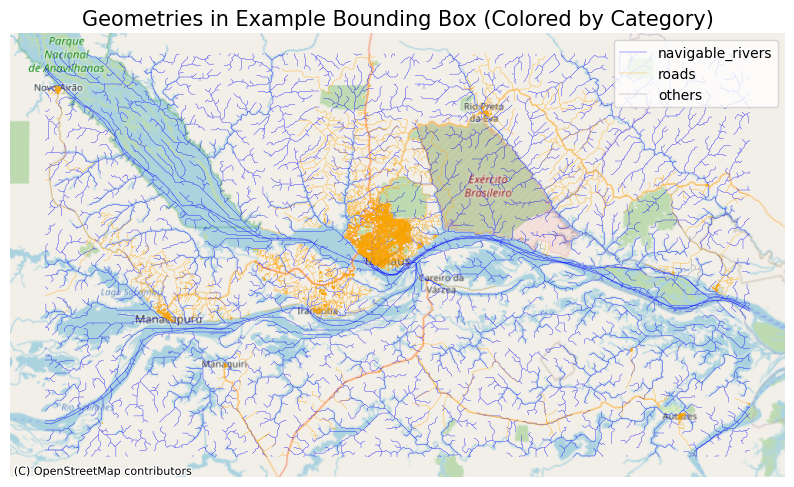

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))

# Define colors for each category
colors = {"navigable_rivers": "blue", "roads": "orange", "others": "gray"}

# Plot each category with different colors
for category in rivers_sample["category"].unique():
    subset = rivers_sample[rivers_sample["category"] == category]
    subset.plot(
        ax=ax,
        color=colors.get(category, "black"),
        linewidth=0.25,
        label=category,
        alpha=1,
    )

ctx.add_basemap(
    ax, crs=rivers_sample.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik
)

ax.set_axis_off()
ax.set_title("Geometries in Example Bounding Box (Colored by Category)", fontsize=15)
ax.legend()
plt.show()

In [10]:
# Function to convert the GeoDataFrame to OSM XML format
def gdf_to_osm_xml(gdf, output_file):
    # Create the root element of the OSM file
    osm_root = etree.Element("osm", version="0.6", generator="GeoDataFrame to OSM")

    for idx, row in gdf.iterrows():

        # Ensure the values used for id attributes are not None
        if row["start_node"] is None or row["end_node"] is None:
            print(f"WARNING: missing node ID. Skipping row {idx}.")
            continue
        if row["edge_id"] is None:
            print(f"WARNING: missing edge ID. Skipping row {idx}.")
            continue

        # Create nodes
        etree.SubElement(
            osm_root,
            "node",
            id=str(row["start_node"]),
            lat=str(row["start_lat"]),
            lon=str(row["start_lon"]),
        )
        etree.SubElement(
            osm_root,
            "node",
            id=str(row["end_node"]),
            lat=str(row["end_lat"]),
            lon=str(row["end_lon"]),
        )

        # Create a way element
        way = etree.SubElement(osm_root, "way", id=str(row["edge_id"]))

        # Add nodes to the way
        etree.SubElement(way, "nd", ref=str(row["start_node"]))
        etree.SubElement(way, "nd", ref=str(row["end_node"]))

        # Add tags to the way
        tags = {
            "highway": row["fclass"],
            "name": row["name"],
            "oneway": row["oneway"] if row["oneway"] else "no",
            "maxspeed": str(row["maxspeed"]) if row["maxspeed"] else None,
            "bridge": row["bridge"] if row["bridge"] else None,
            "tunnel": row["tunnel"] if row["tunnel"] else None,
            "layer": str(row["layer"]) if row["layer"] else None,
            "surface": row["surface"] if row["surface"] else None,
            "lanes": str(row["lanes"]) if row["lanes"] else None,
        }

        for key, value in tags.items():
            if value:  # Only add tag if value is not None
                etree.SubElement(way, "tag", k=key, v=value)

    # Write the XML tree to a file
    tree = etree.ElementTree(osm_root)
    tree.write(output_file, pretty_print=True, xml_declaration=True, encoding="UTF-8")

In [11]:
rivers_parquet[["edge_id", "start_node", "end_node"]].isna().sum()

edge_id          0
start_node    2009
end_node      2009
dtype: int64

In [12]:
rivers_parquet[
    rivers_parquet["start_node"].isna() | rivers_parquet["end_node"].isna()
].explore()

In [13]:
# Convert to OSM (XML) format
output_path = Path(OUTPUT_OSM_FILE)
if not output_path.exists():
    print(f"Converting GeoDataFrame to OSM XML: {OUTPUT_OSM_FILE}")
    # Check if the output directory exists, create if not
    output_path.parent.mkdir(parents=True, exist_ok=True)
    gdf_to_osm_xml(rivers_parquet, OUTPUT_OSM_FILE)
    print(f"Conversion complete: {OUTPUT_OSM_FILE}")
else:
    print(f"OSM file already exists: {OUTPUT_OSM_FILE}")

OSM file already exists: outputs/rivers_amazon.osm


In [14]:
# Convert OSM XML to PBF for OSRM
output_path = Path(OUTPUT_OSM_PBF_FILE)
if not output_path.exists():
    print(f"Converting OSM XML to OSM PBF: {OUTPUT_OSM_PBF_FILE}")
    # Check if the output directory exists, create if not
    output_path.parent.mkdir(parents=True, exist_ok=True)
    !osmium cat {OUTPUT_OSM_XML} -o {OUTPUT_OSM_PBF_FILE} --overwrite
    print(f"Conversion complete: {OUTPUT_OSM_PBF_FILE}")
else:
    print(f"OSM file already exists: {OUTPUT_OSM_PBF_FILE}")


OSM file already exists: outputs/rivers_amazon.osm.pbf


### Process the OSM PBF file with OSRM

We will use the OSRM Docker images to process the OSM PBF file and prepare it for routing.
The profile used is `fluvial.lua`, which is a custom profile designed for waterways.

In [16]:
!docker run --name osrm_extract --rm -t -v "${PWD}:/data" ghcr.io/project-osrm/osrm-backend osrm-extract -p /data/fluvial.lua /data/outputs/rivers_amazon.osm.pbf || echo "osrm-extract failed"

[2025-07-29T20:51:50.727242920] [info] Parsed 0 location-dependent features with 0 GeoJSON polygons
[2025-07-29T20:51:50.729083545] [info] Using script /data/fluvial.lua
[2025-07-29T20:51:50.729101128] [info] Input file: rivers_amazon.osm.pbf
[2025-07-29T20:51:50.729106461] [info] Profile: fluvial.lua
[2025-07-29T20:51:50.729108128] [info] Threads: 10
[2025-07-29T20:51:50.729602253] [info] Parsing in progress..
[2025-07-29T20:51:50.730751378] [info] input file generated by osmium/1.18.0
[2025-07-29T20:51:50.731194920] [info] timestamp: n/a
[2025-07-29T20:51:50.733262295] [info] Using profile api version 0
[2025-07-29T20:51:50.733317545] [info] Parse relations ...
[2025-07-29T20:52:39.442681637] [info] Parse ways and nodes ...
[2025-07-29T20:52:39.444002053] [info] Using profile api version 0
[2025-07-29T20:52:39.444713803] [info] Using profile api version 0
[2025-07-29T20:52:39.445419428] [info] Using profile api version 0
[2025-07-29T20:52:39.446085220] [info] Using profile api versio

In [19]:
!docker run --name osrm_contract --rm -t -v "${PWD}:/data" ghcr.io/project-osrm/osrm-backend osrm-contract /data/outputs/rivers_amazon.osm.pbf || echo "osrm-contract failed"

[2025-07-29T20:57:32.430443842] [info] Input file: /data/outputs/rivers_amazon.osrm
[2025-07-29T20:57:32.430594592] [info] Threads: 10
[2025-07-29T20:57:32.430814092] [info] Reading node weights.
[2025-07-29T20:57:32.439477800] [info] Done reading node weights.
[2025-07-29T20:57:32.439493508] [info] Loading edge-expanded graph representation
[2025-07-29T20:57:32.897622134] [info] merged 11532 edges out of 15656432
[2025-07-29T20:57:32.989996634] [info] initializing node priorities... ok.
[2025-07-29T20:57:34.162439259] [info] preprocessing 3853000 (100%) nodes...
[2025-07-29T20:57:34.162462468] [info] . 10% . 20% . 30% . 40% . 50% . 60% .[renumbered] 70% . 80% . 90% . 100% 100% 
[2025-07-29T20:59:38.899983011] [info] Converting contracted graph with 20021682 to edge list (480520368 bytes)
[2025-07-29T20:59:38.919907886] [info] Getting edges of minimized graph . 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
[2025-07-29T20:59:39.290872887] [info] Contracted graph has 2002168

In [18]:
!docker run --name osrm_partition --rm -t -v "${PWD}:/data" ghcr.io/project-osrm/osrm-backend osrm-partition /data/outputs/rivers_amazon.osrm || echo "osrm-partition failed"

[2025-07-29T20:57:07.388125594] [info] Computing recursive bisection
[2025-07-29T20:57:07.474134344] [info] Loaded compressed node based graph: 3853000 edges, 1730209 nodes
[2025-07-29T20:57:07.505567802] [info]  running partition: 128 1.2 0.25 10 1000 # max_cell_size balance boundary cuts small_component_size
[2025-07-29T20:57:07.612233761] [info] Found 98684 SCC (49 large, 98635 small)
[2025-07-29T20:57:07.612265719] [info] SCC run took: 0.105711s
[2025-07-29T20:57:09.976471179] [info] Full bisection done in 2.17362s
[2025-07-29T20:57:09.992555970] [info] Loaded node based graph to edge based graph mapping
[2025-07-29T20:57:11.199887429] [info] Loaded edge based graph for mapping partition ids: 15644900 edges, 3853000 nodes
[2025-07-29T20:57:11.502611429] [info] Fixed 381 unconnected nodes
[2025-07-29T20:57:11.502649388] [info] Edge-based-graph annotation:
[2025-07-29T20:57:11.502652138] [info]   level 1 #cells 17987 bit size 15
[2025-07-29T20:57:11.502685554] [info]   level 2 #cells

In [ ]:
!docker run --name osrm_contract --rm -t -v "${PWD}:/data" ghcr.io/project-osrm/osrm-backend osrm-contract /data/outputs/rivers_amazon.osm.pbf || echo "osrm-contract failed"

In [20]:
!docker run -t -v "${PWD}:/data" ghcr.io/project-osrm/osrm-backend osrm-customize /data/outputs/rivers_amazon.osrm || echo "osrm-customize failed"

[2025-07-29T20:59:48.226561752] [info] Loaded edge based graph: 15644900 edges, 3853000 nodes
[2025-07-29T20:59:48.249877210] [info] Loading partition data took 1.51368 seconds
[2025-07-29T20:59:48.932120502] [info] Cells customization took 0.682171 seconds
[2025-07-29T20:59:48.932151335] [info] Cells statistics per level
[2025-07-29T20:59:48.940775585] [info] Level 1 #cells 17987 #boundary nodes 279146, sources: avg. 10, destinations: avg. 15, entries: 6861000 (54888000 bytes)
[2025-07-29T20:59:48.941657252] [info] Level 2 #cells 1342 #boundary nodes 27005, sources: avg. 13, destinations: avg. 20, entries: 972230 (7777840 bytes)
[2025-07-29T20:59:48.941720169] [info] Level 3 #cells 90 #boundary nodes 1256, sources: avg. 9, destinations: avg. 13, entries: 34038 (272304 bytes)
[2025-07-29T20:59:48.941727419] [info] Level 4 #cells 3 #boundary nodes 0, sources: avg. 0, destinations: avg. 0, entries: 0 (0 bytes)
[2025-07-29T20:59:48.941729877] [info] Unreachable nodes statistics per level


### Run the OSRM Routing Server with the Processed Data

We will run this command on the background (detached mode) so that we can run other cells in the notebook without stopping the server.

In [21]:
!docker run --name osrm_routing_server_south_america_amazon -t -d -p 5000:5000 -v "${PWD}:/data" ghcr.io/project-osrm/osrm-backend osrm-routed --algorithm mld /data/outputs/rivers_amazon.osrm

8ffe74687ed7daf8f31b7c40020bf58ca5002e13f1765877aa32f11776af9d87


In [24]:
def get_osrm_route(start, end, endpoint="http://localhost:5000"):
    url = f"{endpoint}/route/v1/driving/{start[0]},{start[1]};{end[0]},{end[1]}?steps=true"
    response = requests.get(url)
    return response.json()

In [25]:
start = [-59.868475, -3.190510]
end = [-60.021018, -3.135563]
route = get_osrm_route(start, end)

In [26]:
route

{'code': 'Ok',
 'routes': [{'geometry': 'lcnRnallJxAn@mXpGeoDheDs~BlxEwPzk@{d@zv@gHhh@dChqAnBfM`Vvd@Tz|@lDnF}BhGoGz@}O`k@eDfrCtg@CEhHtHR}AfB',
   'legs': [{'steps': [{'geometry': 'lcnRnallJxAn@',
       'maneuver': {'bearing_after': 209,
        'bearing_before': 0,
        'location': [-59.868555, -3.190466],
        'modifier': 'left',
        'type': 'depart'},
       'mode': 'driving',
       'driving_side': 'right',
       'name': '',
       'intersections': [{'out': 0,
         'entry': [True],
         'bearings': [209],
         'location': [-59.868555, -3.190466]}],
       'weight': 13.6,
       'duration': 13.6,
       'distance': 56.7},
      {'geometry': 'ffnR~bllJeDAcAJcQfGeoDheDs~BlxEwPzk@',
       'maneuver': {'bearing_after': 0,
        'bearing_before': 208,
        'location': [-59.868802, -3.190915],
        'modifier': 'sharp right',
        'type': 'turn'},
       'mode': 'driving',
       'driving_side': 'right',
       'name': '',
       'intersections': [{'out':

In [29]:
def plot_route(start, end, route):
    import folium

    m = folium.Map(
        location=[(start[1] + end[1]) / 2, (start[0] + end[0]) / 2], zoom_start=10
    )
    # Green marker for start
    folium.Marker(
        [start[1], start[0]], icon=folium.Icon(color="green"), popup="Start"
    ).add_to(m)
    # Red marker for end
    folium.Marker([end[1], end[0]], icon=folium.Icon(color="red"), popup="End").add_to(
        m
    )
    # Route geometry (encoded polyline)
    encoded_geometry = route["routes"][0]["geometry"]
    decoded_geometry = polyline.decode(encoded_geometry)
    folium.PolyLine(decoded_geometry, color="blue", weight=2.5, opacity=1).add_to(m)
    return m

In [30]:
plot_route(start, end, route)

In [31]:
start = [-59.853344, -3.136574]
end = [-60.021018, -3.135563]
route = get_osrm_route(start, end)
plot_route(start, end, route)